# AUC vs Average-Precision For Imbalnaced Datasets - An Empirical Simulation

In this notebook we conduct a simulation to empirically test and visualize how class imbalance affects two common performance metrics - [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) and [Average-Precision (AP)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). While AUC summarizes the FPR-TPR curve for all thresholds, the AP metric summarizes the precision-recall curve for all thresholds.

In the simulation we generate some data (two features and a binary target), and evaluate three models on the data, with a natural ordering between them (from best to worst):
1. a logistic regression model, trained on **both features**
2. a logistic regression model, trained on **just one feature**
3. a dummy model, as a reference baseline

Training three models with distinctive order between them will help identify how well each metric quantifies performance.

We will evaluate AP and AUC for each model when training on data from several levels of imbalance - from extremely imbalanced to well-balanced.
Additionaly, we empirically validate an intuitive intepretation for AUC as the probability that given two test samples, a positive one and a negtive one, the model will predict a higher score to the positive one. We check how well this holds even for very imbalanced data.

In [1]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import random
from collections import namedtuple

## Generate a synthetic dataset:

We generate two features, `x1` and `x2` fron uniform (0,1) distribution, and a binary target that is the product of two Bernoulli RVs with success probabilities `x1` and `x2` respectively.

In [2]:
N = 10**7 # size of dataset
M = 10**6 # num of examples per simulation
P = 2 # num of features

In [3]:
X = np.random.random(size=P*N).reshape(N, P)
data = pd.DataFrame(X, columns=['x1','x2'])
data['y'] = np.random.binomial(p=X[:,0], n=1) * np.random.binomial(p=X[:,1], n=1)

positives = data[data['y'] == 1]
negatives = data[data['y'] == 0]

In [4]:
data.y.mean()

0.250036

## Run simulation:

In [5]:
def sample_dataset(fraction_of_positives):
    """
    Generates a subsample of the generated data, with the required fraction of positive target variables.
    """
    n_neg, n_pos = (1.0 - fraction_of_positives) * M , fraction_of_positives * M
    # Sample positive and negative examples:
    positives_samp = positives.sample(int(n_pos), replace=False)
    negatives_samp = negatives.sample(int(n_neg), replace=False)

    # Create train & test sets with required fraction of positives:
    X = pd.concat([positives_samp, negatives_samp]).drop('y', axis=1).values
    y = pd.concat([positives_samp, negatives_samp])['y'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
    return X_train, X_test, y_train, y_test


### Define the core functions for simulation:

In [15]:
def estimate_correct_ordering_prob(y_test, y_preds):
    """
    Estimate the probability that the model that produced the given predictions (y_preds) gives a higher score to 
    a positive sample than to a negative one. 
    i.e we estimate: P(f(x1) > f(x2) | y1=1, y2=0), where f is our model.
    """
    positive_test_indices = [i for i in range(len(y_test)) if y_test[i] == 1]
    negative_test_indices = [i for i in range(len(y_test)) if y_test[i] == 0]
    
    n_estimation = min([len(positive_test_indices), len(negative_test_indices)])
    
    pos_indices_sample = random.sample(positive_test_indices, n_estimation)
    neg_indices_sample = random.sample(negative_test_indices, n_estimation)    
    
    return np.mean(y_preds[pos_indices_sample] >= y_preds[neg_indices_sample])


def _calc_metrics(y_test, y_preds):
    auc = roc_auc_score(y_test, y_preds)
    ap = average_precision_score(y_test, y_preds)
    return auc, ap

def get_model_performance_metrics(X_train, X_test, y_train, y_test):
    """
    Train _ models, and return for each one the AUC and AP metrics:
        1. Logistic regression trained on both predictors
        2. Logistic regression trained on just one predictor
        3. Dummy model, making predictions based on the target class distributions
    """
    performance_metrics = ["lr_auc", "lr_ap", "lr_correct_ordering_prob_estimation",
                           "lr_one_predictor_auc", "lr_one_predictor_ap", 
                           "lr_one_predictor_correct_ordering_prob_estimation",
                           "dummy_auc", "dummy_ap"]
    result = namedtuple("Result", performance_metrics)
    
    # Logistic regression moel that learns using both predictors (x1 and x2):
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_preds = lr.predict_proba(X_test)[:,1]
    result.lr_auc, result.lr_ap = _calc_metrics(y_test, lr_preds)
    result.lr_correct_ordering_prob_estimation = estimate_correct_ordering_prob(y_test, lr_preds)
    
    # Logistic regression model that learns using just one predictor (x1):
    lr_one_predictor = LogisticRegression()
    lr_one_predictor.fit(X_train[:, 0].reshape(-1, 1), y_train)
    lr_one_predictor_preds = lr_one_predictor.predict_proba(X_test[:, 0].reshape(-1, 1))[:, 1]
    result.lr_one_predictor_auc, result.lr_one_predictor_ap = _calc_metrics(y_test, lr_one_predictor_preds)
    result.lr_one_predictor_correct_ordering_prob_estimation = estimate_correct_ordering_prob(y_test, lr_one_predictor_preds)

    # Dummy classifier that predicts with respect to the target distribution:
    dummy = DummyClassifier(strategy='stratified')
    dummy.fit(X_train, y_train)
    dummy_preds = dummy.predict_proba(X_test)[:,1]
    result.dummy_auc, result.dummy_ap = _calc_metrics(y_test, dummy_preds)
    
    
    return result

### Simulation loop

In [28]:
results = {}
imbalances = list(np.linspace(0.001, 0.15, 8)) + [0.2, 0.3, 0.4, 0.5]
for positives_fraction in imbalances:
    print("Running simulation for positive frac = ", positives_fraction)
    X_train, X_test, y_train, y_test = sample_dataset(positives_fraction)
    result = get_model_performance_metrics(X_train, X_test, y_train, y_test)
    results[positives_fraction] = result


Running simulation for positive frac =  0.001
Running simulation for positive frac =  0.022285714285714287
Running simulation for positive frac =  0.04357142857142857
Running simulation for positive frac =  0.06485714285714286
Running simulation for positive frac =  0.08614285714285715
Running simulation for positive frac =  0.10742857142857143
Running simulation for positive frac =  0.12871428571428573
Running simulation for positive frac =  0.15
Running simulation for positive frac =  0.2
Running simulation for positive frac =  0.3
Running simulation for positive frac =  0.4
Running simulation for positive frac =  0.5


### Plot Results:

In [29]:
style_map = {"lr_auc": {"color":'g', "ls":'-'},
            "lr_ap": {"color":"g", "ls":':'},
            
            "dummy_auc":  {"color":'black', "ls":'-'},
            "dummy_ap": {"color":'black', "ls":':'},
            
            "lr_one_predictor_auc": {"color":"blue", "ls":'-'},
            "lr_one_predictor_ap": {"color":"blue", "ls":':'},
             }

metric_names = list(results.values())[0]._fields

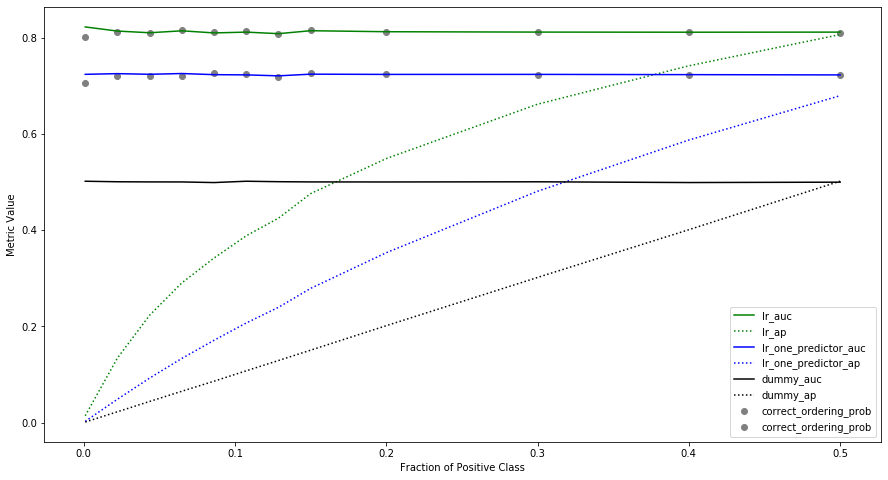

In [31]:
plt.figure(figsize=(15,8))
for metric_name in metric_names:
    if "correct_ordering_prob" in metric_name:
        plt.scatter(imbalances, [getattr(results[pos_frac], metric_name) for pos_frac in imbalances],
                    label="correct_ordering_prob", color='gray')
    else:
        plt.plot(imbalances, [getattr(results[pos_frac], metric_name) for pos_frac in imbalances], label=metric_name,
             ls=style_map[metric_name]['ls'], color=style_map[metric_name]['color'])
plt.legend()
plt.xlabel("Fraction of Positive Class")
plt.ylabel("Metric Value")

plt.show()

### Analysis:
1. In the plot we see the AUC and AP metrics for three models - a dummy model, a "limited" model that can only use one feature, and the "best" model that uses both features.
2. We can see that unlike both AUC and AP correctly order the models, i.e. the best ones gets the highest score and the worst one the lowest.
3. While AUC stays constant when changing the target class imbalance, the AP is directly affetred by the imbalance. 
4. We see that the interpretation of AUC as the probability that the model will give a higher score to a positiv test example than to a negative one holds well even for very imbalanced data, which implies an advantage for AUC when relying on this interpretation.
5. This plot illustrates a problem with AP - just by increasing the fraction of positive examples (say by over-sampling), we can increase the performance metric even for a dummy model.